In [1]:
%load_ext autoreload
%autoreload 2

# Human Activity Detection Using Smartphones (HAR) Dataset: Cursory Comparison of Models

In [2]:
%%HTML
<div align="center">
    <iframe 
        width="560" 
        height="315"
        src="https://www.youtube.com/embed/XOEN9W05_4A?si=msCoG9kEvLrxkKVi" 
        title="HAR Demo Video" 
        frameborder="0" 
        allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" 
        referrerpolicy="strict-origin-when-cross-origin" 
        allowfullscreen
    ></iframe>
</div>

In [ ]:
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import umap.plot
import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_sample_weight
from umap import UMAP

In [4]:
sys.path.append(
    os.path.join(
        Path(os.getcwd()).parents[0].as_posix(),
        "src"
    )
)

In [5]:
from data import HARDataController

In [6]:
idx = pd.IndexSlice

## Loading Data

In [11]:
dc = HARDataController()

In [12]:
dc.load()

## Intro

From https://paperswithcode.com/dataset/har: *Human Activity Detection (HAR) is collected from 30 subjects performing six different activities (Walking, Walking Upstairs, Walking Downstairs, Sitting, Standing, Laying). It consists of inertial sensor data that was collected using a smartphone carried by the subjects.*

<Axes: >

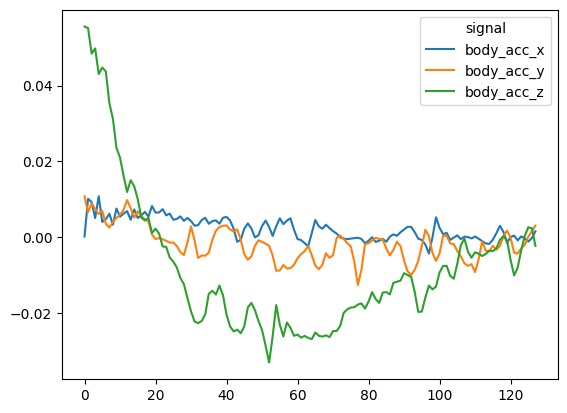

In [17]:
dc.df_train_x.loc[0].reset_index(drop='subject_id').plot(
    y=['body_acc_x', 'body_acc_y', 'body_acc_z']
)

Breakdown by Activities

In [18]:
dc.df_train_y["name"].value_counts()

name
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64

## Baseline Models: XGBoost

HAR comes with a set of features created from sensor data time series:

In [19]:
dc.df_train_x_tr.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
sample,,,,,,,,,,,,,,,,,,,,,
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


- Features provide a good amount of data separation:

In [20]:
mapper = UMAP().fit(
    dc.df_train_x_tr.values
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<Axes: >

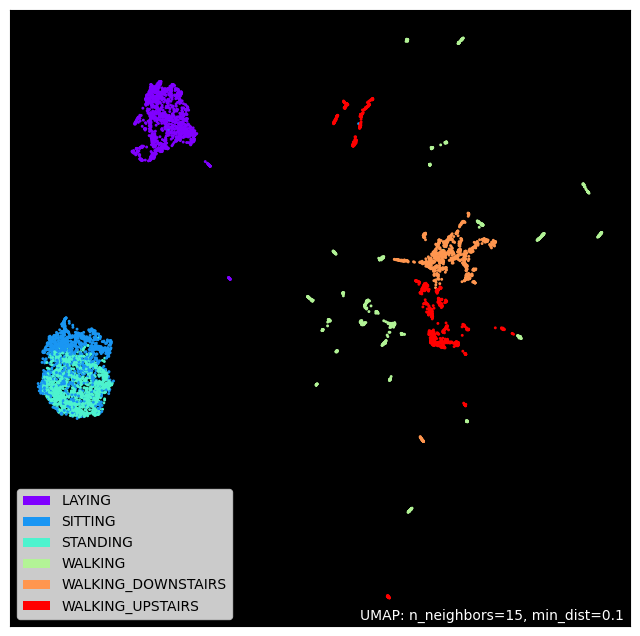

In [21]:
umap.plot.points(
    mapper, 
    labels=dc.df_train_y["name"],
    theme='fire'
)

Baseline classification results using ordinary XGBoost classifier with minimal tuning:

In [26]:
# Data preparation
x_train = dc.df_train_x_tr.values
y_train = dc.df_train_y["label"].values
x_test = dc.df_test_x_tr.values
y_test = dc.df_test_y["label"].values

# dtrain = xgb.DMatrix(x_train, label=y_train)
# dtest = xgb.DMatrix(dc.df_test_x_tr.values, label=dc.df_test_y["label"].values - 1)
eval_set = [(x_train, y_train), (x_test, y_test)]

sample_weight = compute_sample_weight(
    class_weight="balanced",
    y=y_train
)

In [27]:
params_xgb = {
    "n_estimators": 1000,
    "num_class": dc.df_train_y["label"].nunique(),
    "gamma": 0.1,
    "max_depth": 16,
    "subsample": 0.6,
    "colsample_bytree": 6/16,
    "colsample_bylevel": 6/16,
    "colsample_bynode": 6/16,
    "reg_alpha": 0.8,
    "reg_lambda": 0.8,
    "learning_rate": 0.01,
    "eval_metric": "merror",
    "early_stopping_rounds": 100,
    "seed": 42
}

In [28]:
xgb_model = xgb.XGBClassifier(
    objective="multi:softmax",
    **params_xgb
)

In [29]:
_ = xgb_model.fit(
    x_train,
    y_train,
    sample_weight=sample_weight,
    eval_set=eval_set,
    verbose=100
)

[0]	validation_0-merror:0.04693	validation_1-merror:0.16899
[100]	validation_0-merror:0.00585	validation_1-merror:0.07431
[200]	validation_0-merror:0.00258	validation_1-merror:0.07058
[300]	validation_0-merror:0.00136	validation_1-merror:0.06753
[400]	validation_0-merror:0.00027	validation_1-merror:0.06481
[500]	validation_0-merror:0.00014	validation_1-merror:0.06278
[600]	validation_0-merror:0.00000	validation_1-merror:0.06074
[700]	validation_0-merror:0.00000	validation_1-merror:0.05870
[800]	validation_0-merror:0.00000	validation_1-merror:0.05701
[900]	validation_0-merror:0.00000	validation_1-merror:0.05667
[916]	validation_0-merror:0.00000	validation_1-merror:0.05667


In [30]:
xgb_model.best_score, xgb_model.best_iteration

(0.05632846963013234, 817)

In [39]:
df_pred = dc.df_test_y.copy()
df_pred["y_pred"] = xgb_model.predict(x_test)
df_pred["y_pred_prob"] = np.max(xgb_model.predict_proba(x_test), axis=1)
df_pred["subject_id"] = dc.df_test_x.reset_index('timestep').index.unique().to_frame(index=False)["subject_id"]
df_pred["match"] = (df_pred["label"] == df_pred["y_pred"])

In [40]:
df_pred.head()

,label,name,y_pred,y_pred_prob,subject_id,match
sample,,,,,,
0,4,STANDING,4,0.987288,2,True
1,4,STANDING,4,0.985361,2,True
2,4,STANDING,4,0.968441,2,True
3,4,STANDING,4,0.981880,2,True
4,4,STANDING,4,0.990619,2,True


In [41]:
df_match_pct = df_pred.groupby(
    ["subject_id", "name"]
)["match"].mean()

In [42]:
df_match_pct[df_match_pct < 1]

subject_id  name              
2           SITTING               0.695652
4           SITTING               0.920000
            STANDING              0.910714
            WALKING_DOWNSTAIRS    0.977778
            WALKING_UPSTAIRS      0.980769
9           SITTING               0.820000
            STANDING              0.822222
            WALKING_UPSTAIRS      0.816327
10          SITTING               0.814815
            STANDING              0.590909
            WALKING               0.943396
            WALKING_UPSTAIRS      0.617021
12          SITTING               0.941176
            WALKING               0.980000
            WALKING_UPSTAIRS      0.942308
13          SITTING               0.979592
            WALKING_DOWNSTAIRS    0.851064
18          SITTING               0.964912
            WALKING_DOWNSTAIRS    0.418182
20          SITTING               0.984848
            WALKING               0.784314
            WALKING_DOWNSTAIRS    0.888889
Name: match, dtype: flo

In [43]:
print(classification_report(
    y_true=df_pred["label"],
    y_pred=df_pred["y_pred"],
    target_names=df_pred.groupby('label')['name'].value_counts().reset_index()['name'].values.tolist(),
))

                    precision    recall  f1-score   support

           WALKING       0.93      0.97      0.95       496
  WALKING_UPSTAIRS       0.91      0.93      0.92       471
WALKING_DOWNSTAIRS       0.97      0.89      0.93       420
           SITTING       0.94      0.91      0.92       491
          STANDING       0.92      0.94      0.93       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947



In [44]:
print(confusion_matrix(
    y_true=df_pred["label"],
    y_pred=df_pred["y_pred"],
))

[[481   9   6   0   0   0]
 [ 25 440   6   0   0   0]
 [ 10  35 375   0   0   0]
 [  0   1   0 447  43   0]
 [  0   0   0  31 501   0]
 [  0   0   0   0   0 537]]


In [45]:
label_idx = df_pred.loc[
    (df_pred["subject_id"]==18)
    &(df_pred["label"]==3)
].index

In [46]:
mapper = UMAP().fit(
    x_test,
    # y=y_test
)

<Axes: >

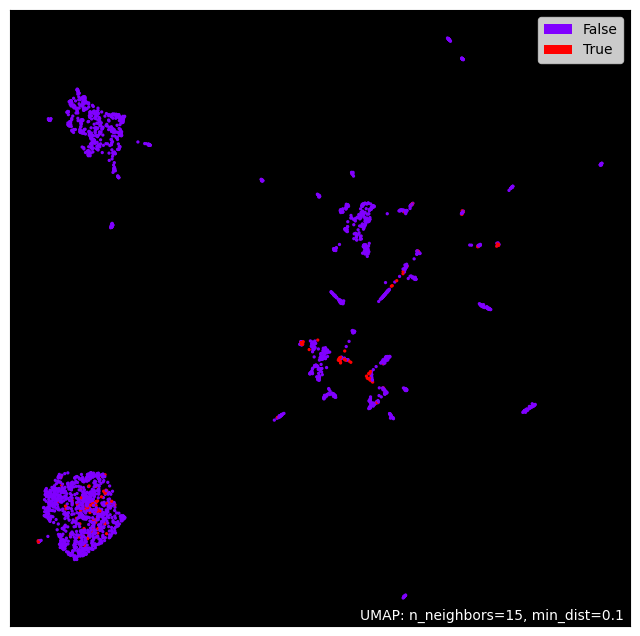

In [47]:
umap.plot.points(
    mapper,
    labels=(df_pred["label"] != df_pred["y_pred"]),
    theme='fire'
)

<Axes: >

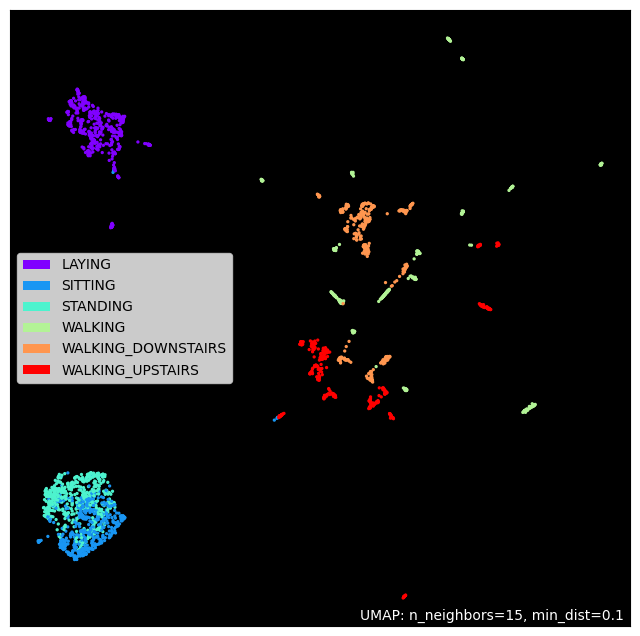

In [48]:
umap.plot.points(
    mapper,
    labels=df_pred["name"],
    theme='fire',
    # subset_points=((df_pred["subject_id"]==18) & (df_pred["label"]==3)).values
)

## Alternative Model: Using Time-Series Directly

From https://github.com/emadeldeen24/CA-TCC, http://arxiv.org/abs/2208.06616

Having multiple measurements per person gives us an additional data augmentation procedure.

In [ ]:
sys.path.append(
    os.path.join(
        Path(os.getcwd()).parents[0].as_posix(),
        "src",
        "ca_tcc"
    )
)

In [ ]:
from torch.utils.data import DataLoader
import torch.nn as nn

from data.har import HARDataset
from ca_tcc.config_files.HAR_Configs import Config
from ca_tcc.dataloader.augmentations import DataTransform
from ca_tcc.models.model import base_Model as base_model
from ca_tcc.models.TC import TC
from ca_tcc.trainer.trainer import model_train, model_evaluate

In [ ]:
config = Config()

In [ ]:
batch_size = 32
training_mode = "SupCon"
device = torch.device("cpu")

In [ ]:
# config.lr = 0.0001
# config.num_epoch = 100

In [ ]:
ds_train_dict = {}

ds_train_dict["samples"] = torch.from_numpy(
    np.stack(
        dc.df_train_x.groupby("sample").apply(lambda x: x.values),
        axis=0
    )
).permute(0, 2, 1)  # Puts the channels into the 2nd dim in line with the CA-TCC model reqs. Weird
    
ds_train_dict["labels"] = torch.from_numpy(
    (dc.df_train_y["label"] - 1).values
)

ds_train_dict["subject_id"] = torch.from_numpy(
    dc.df_train_x.reset_index("timestep").index.unique().to_frame()["subject_id"].values
)

df_map = dc.df_train_x.reset_index("timestep").index.unique().to_frame(index=False)
df_map["label"] = dc.df_train_y.loc[df_map['sample'], "label"] - 1

ds_train_dict["data_map"] = df_map.groupby(
    "label"
).apply(
    lambda x: { 
        int(y): torch.from_numpy(x.loc[x["subject_id"] == y, "sample"].unique())
        for y in x["subject_id"].unique()
    },
    include_groups=False
).to_dict()

torch.save(
    ds_train_dict, 
    os.path.join("train.pt")
)

In [ ]:
ds_test_dict = {}

ds_test_dict["samples"] = torch.from_numpy(
    np.stack(
        dc.df_test_x.groupby("sample").apply(lambda x: x.values),
        axis=0
    )
).permute(0, 2, 1)  # Puts the channels into the 2nd dim in line with the CA-TCC model reqs. Weird
    
ds_test_dict["labels"] = torch.from_numpy(
    (dc.df_test_y["label"] - 1).values
)

ds_test_dict["subject_id"] = torch.from_numpy(
    dc.df_test_x.reset_index("timestep").index.unique().to_frame()["subject_id"].values
)

df_map = dc.df_test_x.reset_index("timestep").index.unique().to_frame(index=False)
df_map["label"] = dc.df_test_y.loc[df_map['sample'], "label"] - 1

ds_test_dict["data_map"] = df_map.groupby(
    "label"
).apply(
    lambda x: { 
        int(y): torch.from_numpy(x.loc[x["subject_id"] == y, "sample"].unique())
        for y in x["subject_id"].unique()
    },
    include_groups=False
).to_dict()

torch.save(
    ds_test_dict, 
    os.path.join("test.pt")
)

In [ ]:
train_dataset = torch.load("train.pt", weights_only=False)
test_dataset = torch.load("test.pt", weights_only=False)

train_dataset = HARDataset(
    train_dataset,
    config,
    training_mode
)

test_dataset = HARDataset(
    test_dataset,
    config,
    training_mode
)

train_dl = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size,
    shuffle=True, 
    drop_last=config.drop_last, 
    num_workers=0
)

test_dl = DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size,
    shuffle=False, 
    drop_last=config.drop_last, 
    num_workers=0
)

In [ ]:
# Model configurations
model = base_model(config).to(device)
temporal_contr_model = TC(config, device).to(device)

In [ ]:
model_optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=config.lr, 
    betas=(config.beta1, config.beta2),
    weight_decay=3e-4
)

temporal_contr_optimizer = torch.optim.Adam(
    temporal_contr_model.parameters(), 
    lr=config.lr,
    betas=(config.beta1, config.beta2), 
    weight_decay=3e-4
)

In [ ]:
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(model_optimizer, 'min')

In [ ]:
for epoch in range(1, config.num_epoch + 1):
# for epoch in range(1, 5):
    # Train and validate
    train_loss, train_acc = model_train(
        model, 
        temporal_contr_model, 
        model_optimizer, 
        temporal_contr_optimizer,
        criterion, 
        train_dl, 
        config, 
        device, 
        training_mode
    )
    valid_loss, valid_acc, _, _ = model_evaluate(model, temporal_contr_model, test_dl, device, "bla")
    # if (training_mode != "self_supervised") and (training_mode != "SupCon"):
    scheduler.step(valid_loss)

    print(f'\nEpoch : {epoch}\n'
                 f'Train Loss     : {train_loss:2.4f}\t | \tTrain Accuracy     : {train_acc:2.4f}\n'
                 f'Valid Loss     : {valid_loss:2.4f}\t | \tValid Accuracy     : {valid_acc:2.4f}')